# Object detection


In [2]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.1.0
The following GPU devices are available: /device:GPU:0


## Apply module

Load a public image from Open Images v4, save locally, and display.

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [3]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


KeyError: 'image_feature_vector'

In [3]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [4]:
def display_image(image):
    #   fig = plt.figure(figsize=(20, 15))
    fig = plt.figure(figsize=(3, 3))
    plt.grid(False)
    plt.imshow(image)

# def download_and_resize_image(url, new_width=256, new_height=256, display=False):
#     _, filename = tempfile.mkstemp(suffix=".jpg")
#     response = urlopen(url)
#     image_data = response.read()
#     image_data = BytesIO(image_data)
#     pil_image = Image.open(image_data)
#     pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
#     pil_image_rgb = pil_image.convert("RGB")
#     pil_image_rgb.save(filename, format="JPEG", quality=90)
#     print("Image downloaded to %s." % filename)
#     if display:
#         display_image(pil_image)
#     return filename


def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                                25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [5]:
def run_detector1(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time (Detection): ", end_time-start_time)

    print(result["detection_class_entities"], result["detection_scores"])
    print(set(result["detection_class_entities"]))
    
    for idx in range(len(result["detection_class_entities"])):
        if result["detection_class_entities"][idx] == b'Building':
            print(idx, result["detection_class_entities"][idx], result["detection_scores"][idx])
    
    
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

In [6]:
def run_detector2(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print(set(result["detection_class_entities"]))
       
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

Found 100 objects.
Inference time (Detection):  0.10272526741027832
[b'Human face' b'Human face' b'Human face' b'Human face' b'Man' b'Man'
 b'Woman' b'Man' b'Clothing' b'Clothing' b'Human nose' b'Clothing'
 b'Person' b'Clothing' b'Person' b'Human nose' b'Human nose' b'Person'
 b'Human eye' b'Human hair' b'Human eye' b'Human eye' b'Human hair'
 b'Human eye' b'Man' b'Woman' b'Clothing' b'Human nose' b'Human eye'
 b'Clothing' b'Clothing' b'Woman' b'Human mouth' b'Person' b'Clothing'
 b'Clothing' b'Human hair' b'Clothing' b'Human nose' b'Human nose'
 b'Human eye' b'Clothing' b'Human nose' b'Human hair' b'Human eye'
 b'Clothing' b'Human mouth' b'Human eye' b'Clothing' b'Clothing'
 b'Clothing' b'Clothing' b'Human hair' b'Human nose' b'Clothing'
 b'Clothing' b'Clothing' b'Clothing' b'Clothing' b'Man' b'Human eye'
 b'Clothing' b'Clothing' b'Human hair' b'Man' b'Human face' b'Human hair'
 b'Human face' b'Clothing' b'Man' b'Human mouth' b'Clothing' b'Clothing'
 b'Clothing' b'Girl' b'Human mouth'

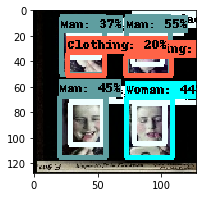

In [12]:
image_path1 = "datasets\\group1_set_128\\set_128\\train\\138982\\ae2cf856f1c12d39.jpg"
run_detector1(detector, image_path1)
# run_detector(detector, image_path1)

{b'Person', b'Human hair', b'Human nose', b'Human mouth', b'Window', b'Clothing', b'Human arm', b'Human eye', b'Human head', b'Glasses', b'Poster', b'Tree', b'Human face', b'Man'}
Font not found, using default font.


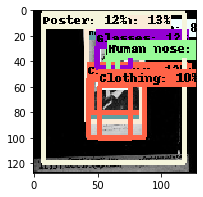

In [16]:
image_path2 = "datasets\\group1_set_128\\set_128\\train\\138982\\e0607570dfd71d89.jpg"
run_detector2(detector, image_path2)

{b'Person', b'Picture frame', b'Plant', b'Clothing', b'Footwear', b'Poster', b'Tree', b'Man'}
Font not found, using default font.


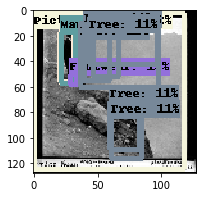

In [17]:
image_path3 = "datasets\\group1_set_128\\set_128\\train\\138982\\f5fdae36a2d2b558.jpg"
run_detector2(detector, image_path3)

{b'Tree', b'Picture frame', b'House'}
Font not found, using default font.


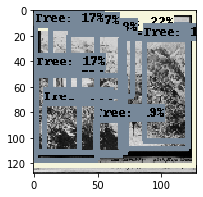

In [18]:
image_path4 = "datasets\\group1_set_128\\set_128\\train\\138982\\4f647425aec45ba3.jpg"
run_detector2(detector, image_path4)

{b'Picture frame', b'Window', b'Building', b'House', b'Skyscraper', b'Poster', b'Tree'}
Font not found, using default font.


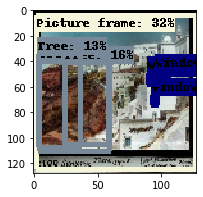

In [20]:
image_path5 = "datasets\\group1_set_128\\set_128\\train\\138982\\8da40f7bdb25c6b4.jpg"
run_detector2(detector, image_path5)

{b'Picture frame', b'Window', b'Plant', b'House', b'Tree'}
Font not found, using default font.


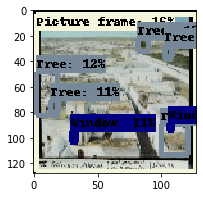

In [21]:
image_path6 = "datasets\\group1_set_128\\set_128\\train\\138982\\9aa65a6851930696.jpg"
run_detector2(detector, image_path6)